## Lecture du réseau routier

In [ ]:
import geopandas as gpd
import momepy
import networkx as nx
from shapely.geometry import LineString, MultiLineString
import geopandas as gpd

file_reseau = "data/reseau route eure.shx"
file_clients = "data/clients.shx"
file_arrivee = "data/arrivée et retour.shx"

# Lire le shapefile avec GeoPandas
gdf_reseau = gpd.read_file(file_reseau)


# Nettoyer le GeoDataFrame
gdf_reseau = gdf_reseau.explode(index_parts=False).reset_index(drop=True)  # sépare les MultiLineString
gdf_reseau = gdf_reseau[gdf_reseau.geometry.type == 'LineString']  # garde uniquement les LineString valides
gdf_reseau = gdf_reseau[~gdf_reseau.geometry.is_empty & gdf_reseau.geometry.notnull()]  # retire les géométries vides

# On converti le geopandas du réseau routier en réseau networkx

g_reseau = momepy.gdf_to_nx(gdf_reseau, approach='primal')

# On vérifie que le réseau est topologiquement connecté (1 seule composante)
components = list(nx.connected_components(g_reseau.to_undirected()))
print(f"Nombre de composantes : {len(components)}")

# fichier clients
gdf_clients = gpd.read_file(file_clients)


# arrivée et retour de la livraison
gdf_liv = gpd.read_file(file_arrivee)






Nombre de composantes : 1


# Visualisation du réseau et des clients

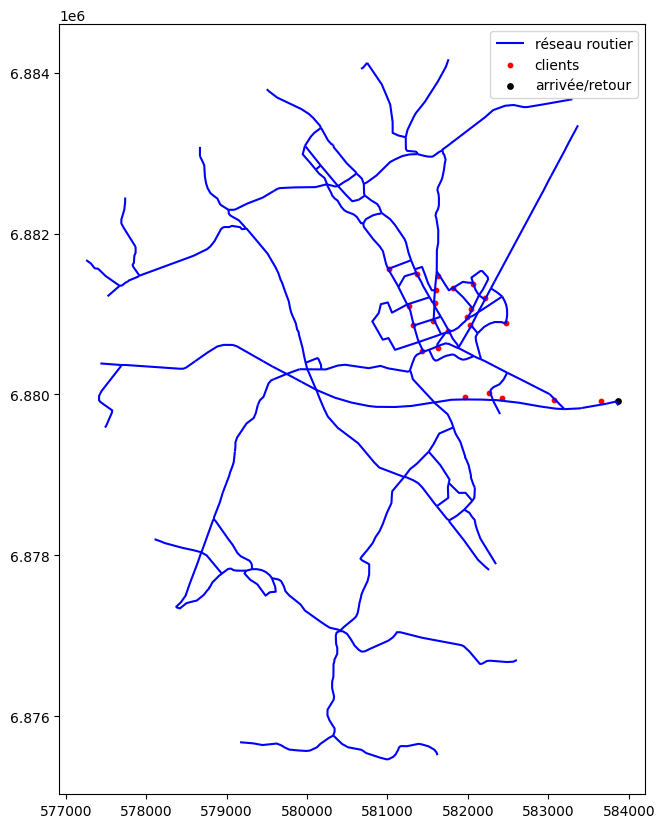

In [37]:
import geopandas as gpd
import matplotlib.pyplot as plt


if gdf_reseau.crs != gdf_clients.crs:
    gdf2 = gdf_clients.to_crs(gdf_reseau.crs)
    
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

gdf_reseau.plot(ax=ax, color='blue', edgecolor='black', legend=True, label='réseau routier')

gdf_clients.plot(ax=ax, color='red', markersize=10, label='clients')
gdf_liv.plot(ax=ax, color='black', markersize=15, label='arrivée/retour')
ax.set_title("")
ax.legend(loc='upper right') 
plt.show()

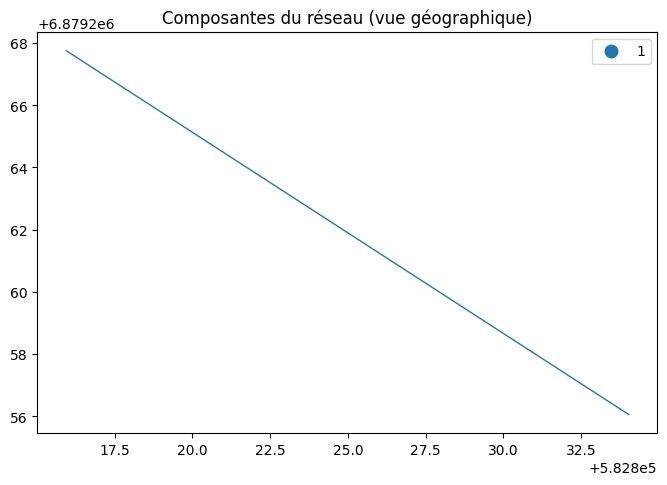

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))
edges_gdf_small.plot(column="component", categorical=True, legend=True, ax=ax, linewidth=1)
plt.title("Composantes du réseau (vue géographique)")
plt.show()


In [17]:
# Identifier les sous-graphes (composantes connexes)
components = list(nx.connected_components(g_reseau.to_undirected()))

print(f"Nombre de composantes : {len(components)}")
print("Taille des 5 plus grandes composantes :", sorted([len(c) for c in components], reverse=True)[:5])

Nombre de composantes : 2
Taille des 5 plus grandes composantes : [139, 2]


## Lecture fichier points de livraision

In [2]:
file_livr = "C:/Users/David/Optim/Optimisation/donnees/Points livraison.shx"

# Lire le shapefile avec GeoPandas
points_livr = gpd.read_file(file_livr)

## Recherche des points du réseau les plus près des points de livraison

In [3]:
nodes_livr = points_livr.geometry.get_coordinates()
nodes_livr['type'] = points_livr['type']

In [7]:
nodes_livr

,x,y,type
0,583009.585282,6.880014e+06,depart
1,581803.833593,6.880498e+06,c1
2,581601.060453,6.880422e+06,c2
3,581520.767733,6.880556e+06,c3
4,581383.317484,6.880660e+06,c5
5,581331.603529,6.880862e+06,c5
6,581247.228129,6.881116e+06,c7
7,581584.729730,6.880942e+06,c9
8,581777.976615,6.880784e+06,c10
9,582001.163158,6.880950e+06,c12


In [19]:
def type_point_reseau(g_reseau,nodes_livr):

    import numpy as np
    nodes_list = list(g_reseau.nodes)
    dico_attribut_nodes = dict()
    capitals = list()
    coordinates = dict()

    for idx, row in nodes_livr.iterrows():
        x_liv = row['x']
        y_liv = row['y']
                
        nearest_node = nodes_list[0]
        X = nearest_node[0]
        Y = nearest_node[1]
        capitals.append(row['type'])


        d_nearest = np.sqrt((x_liv-X)**2 + (y_liv-Y)**2)

        for n in nodes_list[1:]:
            X = n[0]
            Y = n[1]

            d = np.sqrt((x_liv-X)**2 + (y_liv-Y)**2)
            if d < d_nearest:
                nearest_node = n
                d_nearest = d

        coordinates[row['type']] = nearest_node
        
        dico_attribut_nodes[nearest_node] = {'type':row['type']}

    for n in nodes_list:
        if n not in dico_attribut_nodes.keys():
            dico_attribut_nodes[n] = {'type':'interieur'}   

        
    return dico_attribut_nodes,capitals, coordinates

        

In [20]:
dico_attribut_nodes,capitals, coordinates = type_point_reseau(g_reseau,nodes_livr)
nx.set_node_attributes(g_reseau, dico_attribut_nodes)

In [21]:
coordinates

{'depart': (583016.0, 6880004.5),
 'c1': (581880.5, 6880578.6),
 'c2': (581517.5, 6880556.7),
 'c3': (581517.5, 6880556.7),
 'c5': (581327.1, 6880858.1),
 'c7': (581245.2, 6881119.6),
 'c9': (581574.6, 6880937.0),
 'c10': (581767.2, 6880784.4),
 'c12': (581998.5, 6880952.4),
 'c13': (581816.7, 6881326.7),
 'c15': (582059.5, 6881069.8),
 'c17': (582137.8, 6881233.1),
 'c18': (582427.2, 6881219.0),
 'c19': (582468.8, 6880882.5),
 'c21': (582121.8, 6880761.5)}

## Calcul des distances entre chaque points

In [ ]:
short_path = nx.shortest_path(g_reseau, source=coordinates['depart'], target=coordinates['c2'])
length_path = 0.0

for p , c in enumerate(short_path[:-1]):
    edge_data = g_reseau.get_edge_data(short_path[p],short_path[p+1])
    length_path += edge_data[0]['LONGUEUR']


In [43]:
import math
from itertools import combinations

# Compute pairwise distance matrix

def distance(liv1, liv2):
    c1 = coordinates[liv1]
    c2 = coordinates[liv2]

    short_path = nx.shortest_path(g_reseau, source=c1, target=c2)
    length_path = 0.0

    for p , c in enumerate(short_path[:-1]):
        edge_data = g_reseau.get_edge_data(short_path[p],short_path[p+1])
        length_path += edge_data[0]['LONGUEUR']



    return length_path

dist = {(c1, c2): distance(c1, c2) for c1, c2 in combinations(capitals, 2)}